# Data Cleaning & Quality Checks


In this notebook I perform the data cleaning and basic data quality checks for all the datasets used in this project. The goal is to transform the raw GeoJSON files into clean GeoDataFrames that can be used for exploratory data analysis and spatial analysis.

This includes:
- Basic preprocessing (column selection, data types, CRS)
- Consistency and validity checks
- Spatial validity checks
- Fixing or removing invalid records

The cleaned datasets are saved into the `data/processed/` folder and will be used in the EDA notebooks.

## 1. Source
The following datasets were downloaded from the Buenos Aires open data portal.

For more info about each dataset and their columns, visit the following links:


- **Dataset:** Paradas de Colectivo (GeoJSON)

    - **Link:** [Buenos Aires Data - Paradas de Colectivo][bus_stops]

- **Dataset:** Callejero (GeoJSON)

    - **Link:** [Buenos Aires Data - Callejero][callejero]

- **Dataset:** Comunas (GeoJSON)

    - **Link:** [Buenos Aires Data - Comunas][comunas]

- **Dataset** Barrios (GeoJSON)
    - **Link:** [Buenos Aires Data - Barrios][barrios]

[bus_stops]: https://data.buenosaires.gob.ar/dataset/colectivos-paradas/resource/e9699a48-7189-499f-ab3b-d164fd7a1730
[callejero]: https://data.buenosaires.gob.ar/dataset/calles/resource/juqdkmgo-301-resource
[comunas]: https://data.buenosaires.gob.ar/dataset/comunas/resource/b0b627ac-5b47-4574-89ac-6999b63598ee
[barrios]: https://data.buenosaires.gob.ar/dataset/barrios/resource/1c3d185b-fdc9-474b-b41b-9bd960a3806e

## 2. Imports

In [267]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from pathlib import Path
import sys

## 3. Loading Data

In [268]:
sys.path.append(str(Path.cwd().parent / "src"))
PROJECT_ROOT = Path.cwd().parent 
DATA_PATH = PROJECT_ROOT / "data" / "raw" 

DATA_PATH.exists()

True

In [269]:
stops_raw = gpd.read_file(DATA_PATH / "paradas-de-colectivo.geojson")

# Make a copy in order to leave the original file intact
stops = stops_raw.copy()
stops[["DIRECCION", "COMUNA", "BARRIO", "L1", "l1_sen", "L2", "geometry"]].head(3)

,DIRECCION,COMUNA,BARRIO,L1,l1_sen,L2,geometry
0,1524 DEFENSA,1,SAN TELMO,22,V,53,POINT (-58.37099 -34.62566)
1,1528 DEFENSA,1,SAN TELMO,29,I,None,POINT (-58.371 -34.62571)
2,"906 MITRE, BARTOLOME",1,SAN NICOLAS,105,V,None,POINT (-58.37966 -34.60722)


In [270]:
calles_raw = gpd.read_file(DATA_PATH / "callejero.geojson")
calles = calles_raw.copy()
calles[["nomoficial", "alt_izqini", "alt_izqfin", "comuna", "barrio", "geometry"]].head(3)

,nomoficial,alt_izqini,alt_izqfin,comuna,barrio,geometry
0,"CANTILO, INT.",0,0,13.0,Nuñez,"LINESTRING (-58.46219 -34.53452, -58.46267 -34..."
1,"LUGONES, LEOPOLDO AV.",0,0,13.0,Nuñez,"LINESTRING (-58.46515 -34.53465, -58.46496 -34..."
2,"PAZ, GRAL. AV.",2,300,13.0,Nuñez,"LINESTRING (-58.46561 -34.53507, -58.46577 -34..."


In [271]:
comunas_raw = gpd.read_file(DATA_PATH / "comunas.geojson")
comunas = comunas_raw.copy()
comunas.head(3)

,id,objeto,comuna,barrios,perimetro,area,geometry
0,1,COMUNA,1,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,"MULTIPOLYGON (((-58.34892 -34.61698, -58.34901..."
1,2,COMUNA,2,Recoleta,25965.02,6433391.77,"POLYGON ((-58.38039 -34.56847, -58.38037 -34.5..."
2,3,COMUNA,3,"San Cristobal, Balvanera",10486.26,6385992.08,"POLYGON ((-58.41192 -34.59801, -58.4103 -34.59..."


In [272]:
barrios_raw = gpd.read_file(DATA_PATH / "barrios.geojson")
barrios = barrios_raw.copy()
barrios.head(3)

,id,objeto,nombre,comuna,perimetro_,area_metro,geometry
0,1,BARRIO,Agronomia,15,6556.17,2122169.54,"POLYGON ((-58.47589 -34.59173, -58.47598 -34.5..."
1,2,BARRIO,Almagro,5,8537.90,4050752.63,"POLYGON ((-58.416 -34.59786, -58.4157 -34.5978..."
2,3,BARRIO,Balvanera,3,8375.82,4342280.68,"POLYGON ((-58.39294 -34.59964, -58.39277 -34.6..."


## 4. Callejero dataset cleaning

### 4.1 Columns
Let's have a look at the available columns. Only the columns required for name matching and spatial analysis are kept. Column names are then normalized to lowercase and snake_case for consistency.


In [273]:
calles.columns

Index(['id', 'codigo', 'nomoficial', 'alt_izqini', 'alt_izqfin', 'alt_derini',
       'alt_derfin', 'nomanter', 'nom_mapa', 'tipo_c', 'long', 'sentido',
       'observa', 'bicisenda', 'red_jerarq', 'tipo_ffcc', 'comuna', 'com_par',
       'com_impar', 'barrio', 'barrio_par', 'barrio_imp', 'geometry'],
      dtype='object')

Attributes related to traffic direction, or infrastructure are dropped, as they are not relevant for the current analysis. I will rename the **nom_oficial** column to **calle** for simplification.


In [274]:
from normalize_columns import normalize_columns
cols_to_keep = [
    "nomoficial", "barrio", "barrio_par", "barrio_imp",
    "comuna", "com_par", "com_impar", "geometry"
]

calles = calles[cols_to_keep].rename(columns={"nomoficial": "calle"})
calles.columns = normalize_columns(calles.columns)
calles.columns

Index(['calle', 'barrio', 'barrio_par', 'barrio_imp', 'comuna', 'com_par',
       'com_impar', 'geometry'],
      dtype='object')

### 4.2 Dtypes

In [275]:
calles.dtypes

calle           object
barrio          object
barrio_par      object
barrio_imp      object
comuna         float64
com_par        float64
com_impar      float64
geometry      geometry
dtype: object

Let's convert the columns **comuna**, **com_par** and **com_impar** to integers (communes are integers):

In [276]:
cols_to_convert = ["comuna","com_par","com_impar"]
for col in cols_to_convert:
    calles[col] = pd.to_numeric(calles[col], errors="coerce").astype('Int64')

calles[cols_to_convert].dtypes

comuna       Int64
com_par      Int64
com_impar    Int64
dtype: object

### 4.3 String normalization

In [277]:
from normalize_strings import normalize_strings
cols_to_norm = ["calle", "barrio", "barrio_par", "barrio_imp"]

for col in cols_to_norm:
    calles[col] = calles[col].apply(lambda x: normalize_strings(x))

### 4.4 Data Quality

Percentage of missing values:

In [278]:
calles.isna().mean() * 100

calle         0.000000
barrio        5.409887
barrio_par    0.275344
barrio_imp    0.278473
comuna        5.409887
com_par       0.275344
com_impar     0.278473
geometry      0.000000
dtype: float64

Most columns show almost no missing values. The only exceptions are barrio and comuna, with about 5.4% missing values. This is expected, since many street segments are shared between two neighborhoods or communes. In those cases, the information is stored separately for even and odd sides of the street. There are no missing geometries, so the dataset is safe to use for spatial analysis.

### 4.5 Spatial Validity

Let's start by checking that the GeoDataFrames have the EPSG: 4326 CRS, then all the remaining gdf must be the same: 

In [279]:
calles.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Geometry types and bounding boxes are going to be inspected as basic spatial sanity checks to ensure that datasets contain the expected geometries and cover the expected geographic area. In particular, coordinates are expected to fall approximately within the following bounds:
- Latitude between -35 and -34
- Longitude between -59 and -58

In [280]:
calles["geometry"].geom_type.value_counts()

LineString    31960
Name: count, dtype: int64

In [281]:
calles.total_bounds

array([-58.5324417 , -34.70574495, -58.34190732, -34.52947415])

### 4.6 Aggregating street segments

Streets are stored as many small segments, which is great for mapping but not very convenient for analysis. Here I group all segments by street name, merging their geometries and keeping track of all the neighborhoods and communes they pass through. This gives me a cleaner, street-level view of the data

In [282]:
from shapely.ops import unary_union

def unique_values(series):
    return sorted(set(series.dropna()))

calles_agg = (
    calles
    .groupby("calle")
    .agg({
        "barrio_par": unique_values,
        "barrio_imp": unique_values,
        "com_par": unique_values,
        "com_impar": unique_values,
        "geometry": lambda l: unary_union(l)
    })
    .reset_index()
)

calles_agg["barrios"] = (calles_agg["barrio_par"] + calles_agg["barrio_imp"]).apply(lambda x: sorted(set(x)))

calles_agg["comunas"] = (calles_agg["com_par"] + calles_agg["com_impar"]).apply(lambda x: sorted(set(x)))

calles_agg = calles_agg.drop(columns=["barrio_par", "barrio_imp", "com_par", "com_impar"])

In [283]:
calles_agg = gpd.GeoDataFrame(
    calles_agg,
    geometry="geometry",
    crs=calles.crs
)

Number of segments vs unique street names:

In [284]:
print(calles["calle"].count())
print(calles_agg["calle"].count())

31960
2742


### 4.7 Quick sanity check

I inspect a few aggregated records and visualize the merged geometry to ensure the grouping by street name behaved as expected.

In [285]:
calles_agg.head()

,calle,geometry,barrios,comunas
0,1 DE AGOSTO DIA DE LA PACHAMAMA,"LINESTRING (-58.46192 -34.67274, -58.46162 -34...",[VILLA LUGANO],[8]
1,10 DE DICIEMBRE DE 1983,"LINESTRING (-58.39172 -34.64781, -58.39252 -34...",[BARRACAS],[4]
2,10 DE DICIEMBRE DE 1983 PLAZA DE LOS CONGRESOS,"LINESTRING (-58.39142 -34.60925, -58.39148 -34...",[MONSERRAT],[1]
3,10 DE ENERO DE 2001,"LINESTRING (-58.46297 -34.67407, -58.46257 -34...",[VILLA LUGANO],[8]
4,10 DE OCTUBRE DE 1996,"MULTILINESTRING ((-58.40121 -34.6595, -58.4019...",[BARRACAS],[4]


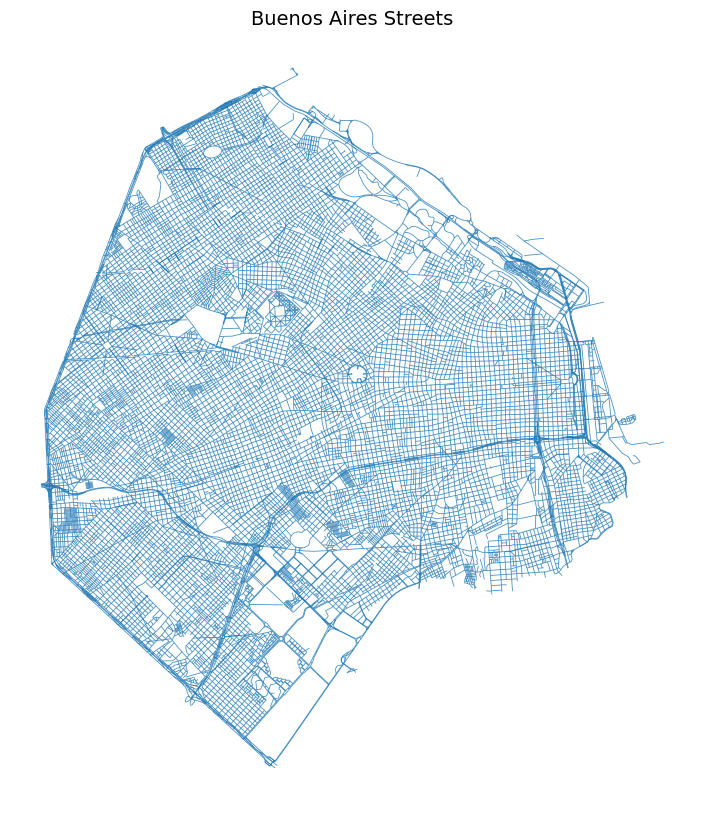

In [286]:
ax = calles_agg.plot(figsize=(10, 10), linewidth=0.6, alpha=0.8)

ax.set_title("Buenos Aires Streets", fontsize=14)
ax.set_axis_off()


A quick map visualization for a sanity check. The streets look continuous and well merged, which confirms that the aggregation by street name worked as expected.

### 4.8 Exporting 

GeoPackage is used instead of GeoJSON because it is more compact, faster to read, and better suited for processed geospatial layers.

In [287]:
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"
output_path = PROCESSED_PATH / "calles.gpkg"

calles_agg.to_file(output_path, layer="calles", driver="GPKG")

## 5. Comunas dataset cleaning

### 5.1 Columns

In [288]:
comunas.columns

Index(['id', 'objeto', 'comuna', 'barrios', 'perimetro', 'area', 'geometry'], dtype='object')

I only keep the columns I will use later. id and objeto are not needed for the analysis, so I drop them and normalize column names.

In [289]:
comunas.drop(columns=["id", "objeto"], inplace=True)
comunas.columns = normalize_columns(comunas.columns)

### 5.2 Dtypes & Data quality

I do a quick check of dtypes and missing values to make sure the table is clean and consistent:

In [290]:
comunas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   comuna     15 non-null     int32   
 1   barrios    15 non-null     object  
 2   perimetro  15 non-null     float64 
 3   area       15 non-null     float64 
 4   geometry   15 non-null     geometry
dtypes: float64(2), geometry(1), int32(1), object(1)
memory usage: 672.0+ bytes


There are no missing values.

#### 5.2.1 Quick quality check:

In the dataset comunas I expect 15 different communes, all with values between 1 an 15:

In [291]:
print(comunas["comuna"].nunique() == 15)
print(comunas["comuna"].between(1, 15).all())

True
True


### 5.3 String Normalization

I normalize the barrios field so it matches the rest of the project (lowercase, accents removed, etc.).

In [292]:
comunas["barrios"] = comunas["barrios"].apply(lambda x: normalize_strings(x))

### 5.4 Spatial validity

As in the previous dataset, I check CRS, geometry types and bounds as a quick spatial sanity check.

In [293]:
comunas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [294]:
comunas["geometry"].geom_type.value_counts()

Polygon         14
MultiPolygon     1
Name: count, dtype: int64

In [295]:
comunas.total_bounds

array([-58.53151731, -34.70535548, -58.33515706, -34.52649644])

### 5.5 Quick sanity check

A quick map helps confirm the polygons look correct and cover the expected area.

In [296]:
comunas.head()

,comuna,barrios,perimetro,area,geometry
0,1,CONSTITUCION SAN TELMO MONSERRAT RETIRO PUERTO...,36351.19,17801036.28,"MULTIPOLYGON (((-58.34892 -34.61698, -58.34901..."
1,2,RECOLETA,25965.02,6433391.77,"POLYGON ((-58.38039 -34.56847, -58.38037 -34.5..."
2,3,SAN CRISTOBAL BALVANERA,10486.26,6385992.08,"POLYGON ((-58.41192 -34.59801, -58.4103 -34.59..."
3,4,BARRACAS LA BOCA PARQUE PATRICIOS NUEVA POMPEYA,35481.84,21690646.89,"POLYGON ((-58.35521 -34.61944, -58.35515 -34.6..."
4,5,ALMAGRO BOEDO,12323.43,6660603.77,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


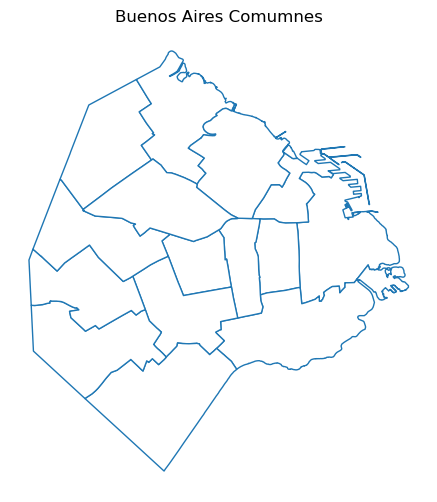

In [297]:
ax = comunas.plot(figsize=(6, 6),color="white",edgecolor="C0")

ax.set_title("Buenos Aires Comumnes")
ax.set_axis_off()

### 5.6 Exporting

GeoPackage is used instead of GeoJSON because it is more compact, faster to read, and better suited for processed geospatial layers.

In [298]:
output_path = PROCESSED_PATH / "comunas.gpkg"

comunas.to_file(output_path, layer="comunas", driver="GPKG")

## 6. Barrios dataset cleaning

### 6.1 Columns

In [299]:
barrios.columns

Index(['id', 'objeto', 'nombre', 'comuna', 'perimetro_', 'area_metro',
       'geometry'],
      dtype='object')

I only keep the fields I need later. I also rename a couple of columns to keep short and consistent names.

In [300]:
barrios = barrios.drop(columns=["id","objeto"]).rename(columns={"area_metro": "area", "perimetro_":"perimetro"})
barrios.columns

Index(['nombre', 'comuna', 'perimetro', 'area', 'geometry'], dtype='object')

### 6.2 Dtypes & Data quality

I do a quick check of dtypes and missing values to make sure everything looks normal.

In [301]:
barrios.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   nombre     48 non-null     object  
 1   comuna     48 non-null     int32   
 2   perimetro  48 non-null     float64 
 3   area       48 non-null     float64 
 4   geometry   48 non-null     geometry
dtypes: float64(2), geometry(1), int32(1), object(1)
memory usage: 1.8+ KB


#### 6.2.1 Quick quality check:

Now in the dataset barrios I expect 48 neighborhoods and their respective communes must be between 1 and 15:

In [302]:
print(barrios["nombre"].nunique())
print(barrios["comuna"].between(1, 15).all())

48
True


### 6.3 String normalization

I normalize barrio names so I can match them reliably with other datasets later.

In [303]:
barrios["nombre"] = barrios["nombre"].apply(lambda x: normalize_strings(x))

### 6.4 Spatial validity

As with the other layers, I check CRS, geometry types and bounds as a quick spatial sanity check.

In [304]:
barrios.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [305]:
barrios["geometry"].geom_type.value_counts()

Polygon    48
Name: count, dtype: int64

In [306]:
barrios.total_bounds

array([-58.53151731, -34.70535548, -58.33515706, -34.52649644])

### 6.5 Quick sanity check

In [307]:
barrios.head()

,nombre,comuna,perimetro,area,geometry
0,AGRONOMIA,15,6556.17,2122169.54,"POLYGON ((-58.47589 -34.59173, -58.47598 -34.5..."
1,ALMAGRO,5,8537.90,4050752.63,"POLYGON ((-58.416 -34.59786, -58.4157 -34.5978..."
2,BALVANERA,3,8375.82,4342280.68,"POLYGON ((-58.39294 -34.59964, -58.39277 -34.6..."
3,BARRACAS,4,12846.58,7955144.83,"POLYGON ((-58.37066 -34.6295, -58.37064 -34.62..."
4,BELGRANO,13,20430.59,8060009.10,"POLYGON ((-58.45167 -34.53565, -58.45168 -34.5..."


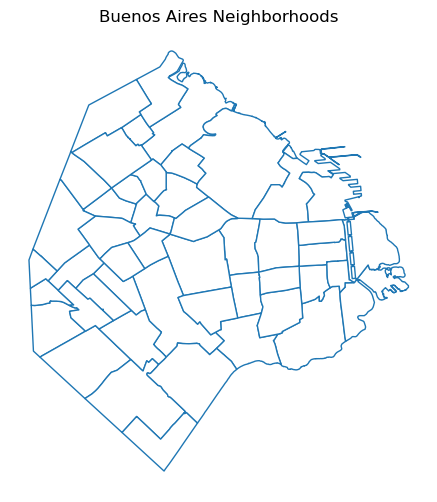

In [308]:
ax = barrios.plot(figsize=(6,6), color="white", edgecolor="C0")
ax.set_title("Buenos Aires Neighborhoods")
ax.set_axis_off()

### 6.6 Exporting

I export this layer as GeoPackage because it is more compact, faster to read

In [309]:
output_path = PROCESSED_PATH / "barrios.gpkg"

barrios.to_file(output_path, layer="barrios", driver="GPKG")

## 7. Stops cleaning

### 7.1 Columns

I keep only the columns I will use later for spatial analysis and aggregation, and drop the rest.

In [310]:
stops.columns

Index(['fid', 'CALLE', 'ALT PLANO', 'DIRECCION', 'coord_X', 'coord_Y',
       'COMUNA', 'BARRIO', 'L1', 'l1_sen', 'L2', 'l2_sen', 'L3', 'l3_sen',
       'L4', 'l4_sen', 'L5', 'l5_sen', 'L6', 'l6_sen', 'geometry'],
      dtype='object')

In [311]:
cols_to_drop = ['fid', 'coord_X', 'coord_Y',
                'l1_sen', 'l2_sen', 'l3_sen', 'l4_sen', 'l5_sen', 'l6_sen']
stops = stops.drop(columns=cols_to_drop).rename(columns={"ALT PLANO":"altura"})
stops.columns = normalize_columns(stops.columns)
stops.columns

Index(['calle', 'altura', 'direccion', 'comuna', 'barrio', 'l1', 'l2', 'l3',
       'l4', 'l5', 'l6', 'geometry'],
      dtype='object')

I dropped operational or redundant fields (ids, coords, line directions) to simplify the dataset.

### 7.2 Dtypes

I check the dtypes to make sure numeric fields are stored correctly.

In [312]:
stops.dtypes

calle          object
altura         object
direccion      object
comuna         object
barrio         object
l1             object
l2             object
l3             object
l4             object
l5             object
l6             object
geometry     geometry
dtype: object

#### 7.2.1 **l1-l6** and **comuna** to integers
Now I will convert the columns **l1-l6** and **comuna** to int type (bus lines and commune numbers are integers):

In [313]:
cols_to_convert = ["comuna","l1", "l2", "l3", "l4", "l5", "l6"]
for col in cols_to_convert:
    stops[col] = pd.to_numeric(stops[col], errors="coerce").astype('Int64')

stops[cols_to_convert].dtypes

comuna    Int64
l1        Int64
l2        Int64
l3        Int64
l4        Int64
l5        Int64
l6        Int64
dtype: object

#### 7.2.2 New column
I will create a column **n_lines** as the number of non-null line fields (**l1-l6**) per stop

In [314]:
line_cols = ["l1", "l2", "l3", "l4", "l5", "l6"]
stops["n_lines"] = stops[line_cols].notna().sum(axis=1)
stops[["direccion","n_lines"]].head()

,direccion,n_lines
0,1524 DEFENSA,2
1,1528 DEFENSA,1
2,"906 MITRE, BARTOLOME",1
3,51 REGIMIENTO DE PATRICIOS AV.,3
4,389 REGIMIENTO DE PATRICIOS AV.,2


### 7.3 Data quality

I calculate missing values for the main fields to confirm the dataset is complete enough.

In [315]:
stops_missing_perc = (stops[["calle","altura","direccion","barrio","comuna","n_lines","geometry"]].isna()
        .mean()
        .mul(100)
        .sort_values(ascending=False))
stops_missing_perc

altura       0.746912
direccion    0.043091
barrio       0.014364
calle        0.000000
comuna       0.000000
n_lines      0.000000
geometry     0.000000
dtype: float64

Overall, the dataset presents a very high level of completeness, with all critical fields showing less than 1% of missing values. In particular, both **calle** and **geometry**, which are essential for spatial and semantic analysis, show 0% missing values.

#### 7.3.1 Encoding/Text issues
While exploring the **paradas-de-colectivo** GeoJSON file, I noticed that some characters (e.g., `Ñ`, accented vowels) appear corrupted in the fields **calle**, **direccion**, and **barrio** (e.g., `NU�EZ` instead of `NUÑEZ`). This � symbol is the Unicode *replacement character* (U+FFFD). There are also some values that have `?`. In the next cells, I quantify how many rows are affected and list the most frequent corrupted values.

Let's see what are the most corrupted values per column:

In [316]:
import re 

corrupt_pattern = re.compile(r"[\ufffd?]")

cols_to_check = ["calle","direccion","barrio"]
for col in cols_to_check:
    corrupted_vals = stops.loc[
        (stops[col].str.contains(corrupt_pattern, na=False)),
        col]
    print(f"The most corrupted values in {col} are:")
    display(corrupted_vals.value_counts().head())

The most corrupted values in calle are:


calle
CASTA�ARES AV.                    23
ALEJANDRO MARGARI�OS CERVANTES    21
RODRIGUEZ PE�A                    17
PRES. LUIS SAENZ PE�A             14
NU�EZ                             14
Name: count, dtype: int64

The most corrupted values in direccion are:


direccion
CALLE INTERNA, PABELL�N 1, C.U.    3
CALLE INTERNA, PABELL�N 3, C.U.    2
CALLE INTERNA, PABELL�N 2, C.U.    2
24 RODRIGUEZ PE�A                  1
240 RODRIGUEZ PE�A                 1
Name: count, dtype: int64

The most corrupted values in barrio are:


barrio
NU�EZ    74
Name: count, dtype: int64

Let's see what the percentage of values with encoding issues are:

In [317]:
stops["has_encoding_issue"] = (
    stops[["calle","direccion", "barrio",]]
    .astype(str)
    .apply(lambda col: col.str.contains(corrupt_pattern))
    .any(axis=1)
)
before_perc = stops["has_encoding_issue"].mean() * 100
before_perc

np.float64(3.4903763286411955)

First I will normalize strings the DataFrame. I will not delete `�`and `?` so later I can work only with the corrupted strings.

In [318]:
cols_to_norm = ["calle","direccion","barrio"]

for col in cols_to_norm:
    stops[cols_to_norm] = stops[cols_to_norm].map(lambda x: normalize_strings(x, keep_replacement_char=True, keep_question_mark=True))

I apply a matching strategy to map corrupted street names to valid ones, and manually fix the few remaining cases.

Let's grab all the corrupted values:

In [319]:
corrupt_names = stops.loc[stops["calle"].str.contains(r"\ufffd|\?", regex=True), "calle"].unique()
corrupt_names

array(['RODRIGUEZ PE�A', 'PRES LUIS SAENZ PE�A',
       'PRES ROQUE SAENZ PE�A AV', 'ALEJANDRO MARGARI�OS CERVANTES',
       'MU�ECAS', 'ALBARI�O', 'COLOMBIA AV Y CERVI�O AV', 'CERVI�O AV',
       'HUMBERTO 1�', 'MU�IZ', 'CASTA�ARES AV', 'CA�ADA DE GOMEZ',
       'NU�EZ', 'O�BRIEN', 'NICASIO ORO�O', 'ESPA�A AV', 'A�ASCO',
       'VILLAFA�E WENCESLAO'], dtype=object)

Now let's try to match the corrupted values with the normal ones in calles_agg DataFrame:

In [320]:
matches = {}

for cname in corrupt_names:
    pattern = cname.replace("\ufffd", ".?")
    mask = calles_agg["calle"].str.contains(pattern, regex=True, na=False)
    candidates = calles_agg.loc[mask, "calle"].unique().tolist()
    matches[cname] = [c for c in candidates if len(c) == len(cname) or len(c) == len(cname) - 1]

matches

{'RODRIGUEZ PE�A': ['RODRIGUEZ PEÑA'],
 'PRES LUIS SAENZ PE�A': [],
 'PRES ROQUE SAENZ PE�A AV': [],
 'ALEJANDRO MARGARI�OS CERVANTES': [],
 'MU�ECAS': ['MUÑECAS'],
 'ALBARI�O': ['ALBARIÑO'],
 'COLOMBIA AV Y CERVI�O AV': [],
 'CERVI�O AV': ['CERVIÑO AV'],
 'HUMBERTO 1�': ['HUMBERTO 1'],
 'MU�IZ': ['MUÑIZ'],
 'CASTA�ARES AV': ['CASTAÑARES AV'],
 'CA�ADA DE GOMEZ': ['CAÑADA DE GOMEZ'],
 'NU�EZ': ['NUÑEZ'],
 'O�BRIEN': ['OBRIEN'],
 'NICASIO ORO�O': [],
 'ESPA�A AV': ['ESPAÑA AV'],
 'A�ASCO': ['AÑASCO'],
 'VILLAFA�E WENCESLAO': ['VILLAFAÑE WENCESLAO']}

Now i will correct the remaining values hardcoding them, using public information of the well known streets names: 

In [321]:
manual_fixes = {
    "ALEJANDRO MARGARI�OS CERVANTES": ["ALEJANDRO MAGARIÑOS CERVANTES"],
    "PRES LUIS SAENZ PE�A": ["PRES LUIS SAENZ PEÑA"],
    "PRES ROQUE SAENZ PE�A AV": ["PRES ROQUE SAENZ PEÑA AV"],
    "NICASIO ORO�O": ["NICASIO OROÑO"],
    "COLOMBIA AV Y CERVI�O AV": ["COLOMBIA AV Y CERVIÑO AV"],
}
matches.update(manual_fixes)

Now replace the values with the mapping, and also i will correct the value NU�EZ in the column **barrio** with the correct name (NUÑEZ):

In [322]:
# Grab only the values with a coincidence
mapping = {
    k: v[0]
    for k, v in matches.items()
    if len(v) == 1
}
stops["calle"] = stops["calle"].replace(mapping)
stops["barrio"] = stops["barrio"].replace(to_replace="NU\ufffdEZ", value="NUÑEZ", regex=False)

I reconstruct direccion for the corrupted rows using altura + calle, since that is the standard format.

In [323]:
stops["direccion_fixed"] = (
    stops["altura"].fillna("").astype(str).str.strip() + " " +
    stops["calle"].fillna("").astype(str).str.strip()
).str.strip()


I only replace direccion where it is missing or corrupted, so clean values remain unchanged.

In [324]:
mask_bad_dir = (
    stops["direccion"].isna() |
    stops["direccion"].str.contains(r"[\ufffd?]", regex=True, na=False)
)

stops.loc[mask_bad_dir, "direccion"] = stops.loc[mask_bad_dir, "direccion_fixed"]

Let's see the percentage of encoding issues left: 

In [325]:
stops["has_encoding_issue"] = (
    stops[["calle", "barrio","direccion"]]
    .apply(lambda col: col.str.contains(corrupt_pattern))
    .any(axis=1)
)
after_perc = stops["has_encoding_issue"].mean() * 100
after_perc

np.float64(0.0)

The figure below compares the percentage of rows affected by encoding issues before and after the correction process.

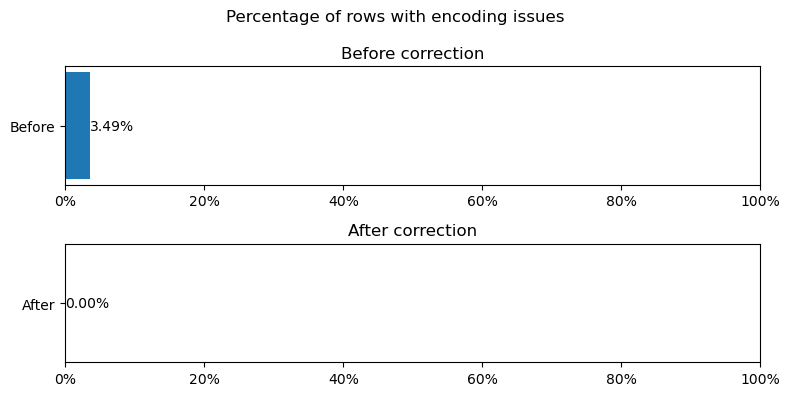

In [326]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

axes[0].set_title("Before correction")
axes[0].barh(["Before"], [before_perc])
axes[0].set_xlim(0, 100)
axes[0].xaxis.set_major_formatter(PercentFormatter())
axes[0].text(before_perc, 0, f"{before_perc:.2f}%", va="center")

axes[1].set_title("After correction")
axes[1].barh(["After"], [after_perc])
axes[1].set_xlim(0, 100)
axes[1].xaxis.set_major_formatter(PercentFormatter())
axes[1].text(after_perc, 0, f"{after_perc:.2f}%", va="center")

fig.suptitle("Percentage of rows with encoding issues", fontsize=12)
plt.tight_layout()

#### 7.3.2 Consistency & Validity
Let's check if the number of communes and neighborhoods matches the official numbers:

In [ ]:
n_comunes_before = stops["comuna"].nunique()
n_neighborhoods_before = stops["barrio"].nunique()
print(f"There are {n_comunes_before} distinct communes (officially must be 15)")
print(f"There are {n_neighborhoods_before} distinct neighborhoods (officially must be 48)")

There are 16 distinct communes (officialy must be 15)
There are 49 distinct neighborhoods (officialy must be 48)


Now let's see what are this wrong values:

In [328]:
invalid_communes = stops[~stops["comuna"].between(1, 15)]
invalid_communes[["calle","altura", "comuna", "barrio"]]

,calle,altura,comuna,barrio
5234,DR RICARDO BALBIN AV,3783,76,SAAVEDRA


In [329]:
invalid_neighborhoods = set(stops["barrio"].unique()) - set(barrios["nombre"].unique())
invalid_neighborhoods

{'BARRANCAS', None, 'VELEZ SARFIELD', 'VILLA ORTUZA'}

The inconsistencies were caused by spelling errors. I will correct them manually, using official neighborhood names as reference. Also, an invalid commune code (76) was found, based on the associated neighborhood I will correct it to commune 12.

In [330]:
correct_neighborhoods = {"BARRANCAS": "BARRACAS",
                         "VELEZ SARFIELD": "VELEZ SARSFIELD",
                         "VILLA ORTUZA": "VILLA ORTUZAR",
                         None: None}

stops["comuna"] = stops["comuna"].replace(76, 12)
stops["barrio"] = stops["barrio"].replace(correct_neighborhoods)

n_comunes_after = stops["comuna"].nunique()
n_neighborhoods_after = stops["barrio"].nunique()
print(f"There are {n_comunes_after} distincs communes, and officialy must be 15")
print(f"There are {n_neighborhoods_after} distincs neighborhoods, and officialy must be 48")

There are 15 distincs communes, and officialy must be 15
There are 48 distincs neighborhoods, and officialy must be 48


After correcting invalid values, the dataset now matches the official information of Buenos Aires:
- 15 communes
- 48 neighborhoods

This ensures consistency with authoritative reference datasets and prevents downstream analytical errors.

### 7.4 Spatial validity

I run the usual CRS/type/bounds checks to make sure geometry looks correct.

In [331]:
stops.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [332]:
stops["geometry"].geom_type.value_counts()

Point    6962
Name: count, dtype: int64

In [333]:
stops.total_bounds

array([-5.83445535e+08, -3.47006587e+01, -5.83423400e+01, -3.45364800e+01])

This result shows that there is at least one geometry outside the expected bounds. To identify the problematic records, we compare the stop locations against the bounding box defined by the **comunas** dataset, which represents the official spatial extent of CABA.

In [334]:
from shapely.geometry import box
caba_bbox = box(*comunas.total_bounds)

out_of_bounds = stops[~stops.geometry.within(caba_bbox)]
out_of_bounds.shape[0]

1

It is only one row, so the record is removed with no meaningful impact on the analysis.

In [335]:
stops = stops.drop(out_of_bounds.index)
stops.total_bounds

array([-58.5304892, -34.7006587, -58.34234  , -34.53648  ])

After removing the out-of-bounds geometry, the spatial extent of the stops dataset is consistent with the expected geographic bounds of CABA.

### 7.5 Remove unused columns

Now that the main fixes are done, I drop columns that are no longer needed to keep the dataset clean and lightweight.

In [336]:
stops = stops[["calle","direccion","comuna","barrio","l1","l2","l3","l4","l5","l6","n_lines","geometry"]]

### 7.6 Quick sanity check

I do a quick sanity check to make sure the final table looks consistent and the geometry is still valid.

In [337]:
stops.head()

,calle,direccion,comuna,barrio,l1,l2,l3,l4,l5,l6,n_lines,geometry
0,DEFENSA,1524 DEFENSA,1,SAN TELMO,22,53,<NA>,<NA>,<NA>,<NA>,2,POINT (-58.37099 -34.62566)
1,DEFENSA,1528 DEFENSA,1,SAN TELMO,29,<NA>,<NA>,<NA>,<NA>,<NA>,1,POINT (-58.371 -34.62571)
2,BARTOLOME MITRE,906 MITRE BARTOLOME,1,SAN NICOLAS,105,<NA>,<NA>,<NA>,<NA>,<NA>,1,POINT (-58.37966 -34.60722)
3,REGIMIENTO DE PATRICIOS AV,51 REGIMIENTO DE PATRICIOS AV,4,BARRACAS,93,70,74,<NA>,<NA>,<NA>,3,POINT (-58.37066 -34.63023)
4,REGIMIENTO DE PATRICIOS AV,389 REGIMIENTO DE PATRICIOS AV,4,BARRACAS,10,22,<NA>,<NA>,<NA>,<NA>,2,POINT (-58.37036 -34.63341)


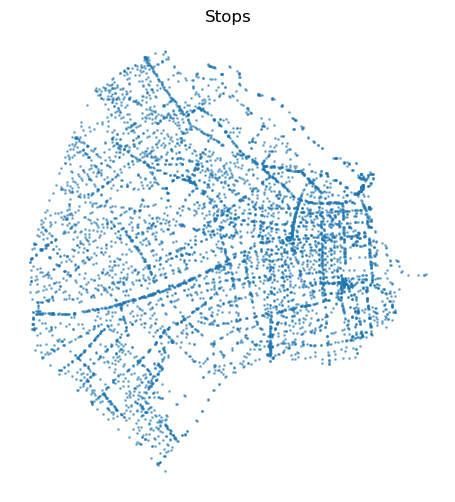

In [338]:
ax = stops.plot(figsize=(6,6), markersize=1, alpha=0.5)
ax.set_title("Stops")
ax.set_axis_off()

### 7.7 Exporting

I export the cleaned stops as GeoPackage because it is smaller and faster to read.

In [339]:
output_path = PROCESSED_PATH / "stops.gpkg"
stops.to_file(output_path, layer="stops", driver="GPKG")